## Course Preference Statistics

This notebook is intended to generate a helpful overview regarding IK participants' course preferences as communicated in their registration data.

In particular, participants hand in lists of courses they would like to visit. During scheduling, we have to take that into account in two major ways:

1. We should not schedule courses in the same time slot that many people which to visit at the same time. In essence, for each time slot we wish to minimize the number of co-occurences.
2. We should assign larger rooms to larger courses. This can still be swapped live, but registration data should get us a first reasonable idea.

In [1]:
# set up a list of courses as ground truth
courses = ['IC1', 'IC2', 'IC3', 'IC4',
           'MC1', 'MC2', 'MC3', 'MC4', 'MC5',
           'FC01', 'FC02', 'FC03', 'FC04',
           'FC05', 'FC06', 'FC07', 'FC08',
           'FC09', 'FC10', 'FC11', 'FC12', 'FC13',
           'PC1', 'PC2', 'PC3', 'PC4',
           'PRFC1', 'PRFC2', 'PRFC3']
exclusions = ['ET1', 'ET2', 'ET3', 'ET4', 'PAN1', 'DB1']
synonyms = {
    'ET01' : 'ET1',
    'ET02' : 'ET2',
    'ET03' : 'ET3',
    'ET04' : 'ET4',
    'IC01' : 'IC1',
    'IC02' : 'IC2',
    'IC03' : 'IC3',
    'IC04' : 'IC4',
    'IC5' : 'MC5',
    'CB1' : 'DB1',
    'AC1' : 'MC1',
    'AC2' : 'MC2',
    'AC3' : 'MC3',
    'AC4' : 'MC4',
    'AC5' : 'MC5',
    'AC01' : 'MC1',
    'AC02' : 'MC2',
    'AC03' : 'MC3',
    'AC04' : 'MC4',
    'AC05' : 'MC5',
    'MC01' : 'MC1',
    'MC02' : 'MC2',
    'MC03' : 'MC3',
    'MC04' : 'MC4',
    'AC5' : 'MC5',
    'FCO1' : 'FC01',
    'FCO5' : 'FC05',
    'FC1' : 'FC01',
    'FC2' : 'FC02',
    'FC3' : 'FC03',
    'FC4' : 'FC04',
    'FC5' : 'FC05',
    'FC6' : 'FC06',
    'FC7' : 'FC07',
    'FC8' : 'FC08',
    'FC9' : 'FC09',
    'PRFC01' : 'PRFC1',
    'PRFC02' : 'PRFC2',
    'PRFC03' : 'PRFC3',
    'PROFC1' : 'PRFC1',
    'PROFC2' : 'PRFC2',
    'PROFC3' : 'PRFC3',
}

# set up a regular expression for course strings
import re
course_regex = re.compile('\w\w+\d+')

# in a first step, load the registration data
import json
filename = 'registration_data.txt';

course_preferences = []
num = 0
with open(filename) as f:
    for line in f:
        # check if the current line is JSON data
        if not line.startswith('{'):
            continue
        # if so, parse the json content
        datum = json.loads(line)
        num += 1
        # from the registration data, extract only the 'courses' field for each participant
        # and transform it into python lists
        course_list_str = datum['courses']
        if course_list_str == '':
            continue
        # look for every course id in the string
        course_matches = course_regex.findall(course_list_str)
        course_list = []
        # check if it is in the ground truth list
        for course in course_matches:
            course = course.upper()
            # match course against synonyms
            if course in synonyms:
                course = synonyms[course]
            # match course against exclusions
            if course in exclusions:
                continue
            if course in courses:
                # if so, add it to the output list
                course_list.append(course)
            else:
                # if not, throw an exception
                raise ValueError('Found invalid course ID %s in registration data of %s %s' %
                                 (course, datum['first_name'], datum['last_name']))
        # append the course list
        course_preferences.append(course_list)
print('finished loading data from %d participants' % num)

finished loading data from 177 participants


In [2]:
# generate a histogram over the courses
histogram = {}
# start with zero entries for all courses
for course in courses:
    histogram[course] = 0
# then count all mentions
for course_list in course_preferences:
    for course in course_list:
        histogram[course] = histogram[course] + 1
# plot a bar graph
import matplotlib.pyplot as plt
x = list(range(len(courses)))
y = []
for course in courses:
    y.append(histogram[course])
    
plt.figure(figsize=(20,8))
plt.bar(x, y, align='center')
plt.xticks(x, courses)
plt.xlabel('Courses')
plt.ylabel('#mentions')
plt.title('Course Popularity')
plt.show()

<Figure size 2000x800 with 1 Axes>

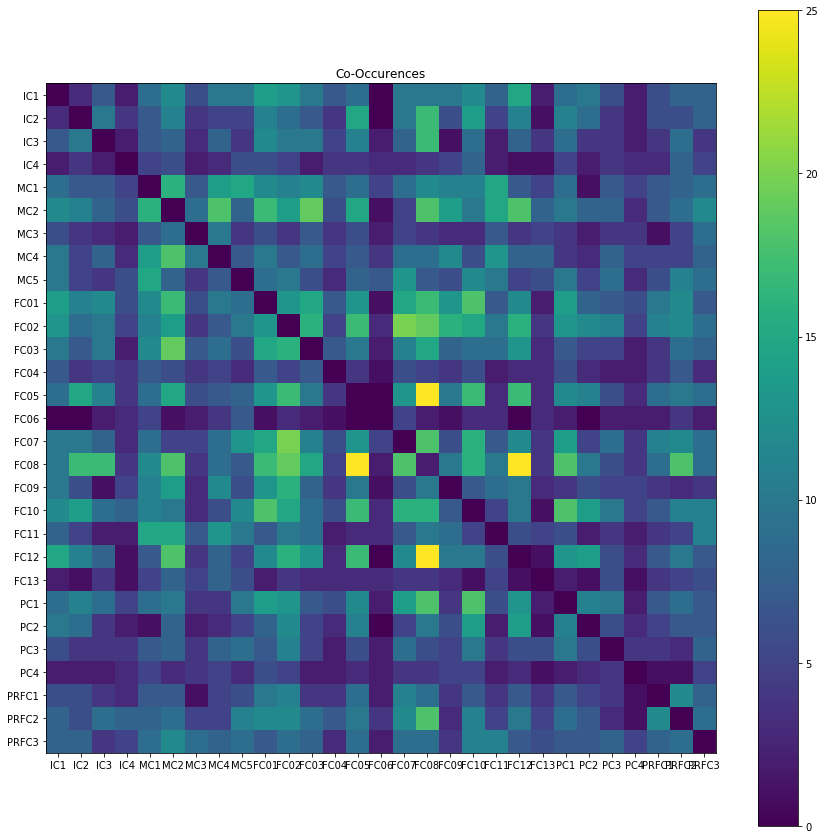

In [3]:
# generate a co-occurence matrix over all courses
import numpy as np
C = np.zeros((len(courses), len(courses)))
# generate a mapping from course names to indices
course_to_idx = {}
for i in range(len(courses)):
    course_to_idx[courses[i]] = i
# then fill the co-occurence matrix
for course_list in course_preferences:
    # iterate over all pairs of courses in the current course list
    for k in range(len(course_list)):
        for l in range(k+1,len(course_list)):
            # retrieve the corresponding indices
            i = course_to_idx[course_list[k]]
            j = course_to_idx[course_list[l]]
            # increment the matrix entry
            C[i, j] += 1
            C[j, i] += 1
# show the matrix
plt.figure(figsize=(15,15))
plt.imshow(C)
plt.xticks(np.arange(len(courses)), courses)
plt.yticks(np.arange(len(courses)), courses)
plt.title('Co-Occurences')
plt.colorbar()
plt.show()

```
# initialize the course blocks automatically with courses that have the least number of co-occurences

# because each course has four time slots, six blocks fit in one week
K = 6
# initialize the remaining courses
remaining = list(range(len(courses)))
# we initialize the blocks with courses that have the least number of co-occurences
seeds = np.sort(np.argsort(np.sum(C[remaining, :], axis=1))[:K])
clusters = []
for i in range(K-1, -1, -1):
    clusters.append([remaining[seeds[i]]])
    del remaining[seeds[i]]
```

In [6]:
# initialize the course blocks manually, e.g. based on external constraints
clusters = [
    ['IC2', 'FC09', 'FC10', 'FC13', 'PC2', 'PRFC2'],
    ['FC07', 'IC4', 'FC10', 'FC12', 'PC2', 'MC1'],
    ['FC03', 'IC3', 'PC3', 'PC4', 'PRFC1'],
    ['IC1', 'FC02', 'FC08'],
    ['MC2', 'FC05', 'FC06', 'FC11', 'PC1'],
    ['FC01', 'FC04', 'MC3', 'MC4', 'MC5', 'PRFC3']
]
K = len(clusters)

remaining = set(range(len(courses)))

# transform identifiers to indices and remove
# the already used courses from 'remaining'
for k in range(len(clusters)):
    for j in range(len(clusters[k])):
        i = course_to_idx[clusters[k][j]]
        clusters[k][j] = i
        if i in remaining:
            remaining.remove(i)

remaining = list(remaining)

In [7]:
# now, generate a minimum co-occurence clustering of courses. These clusters can then
# be used to generate a schedule because we usually cluster courses that then occur in
# a consistent block to make the schedule easier to understand and handle.
#
# Note that this algorithm is essentially the same as the maximum diversity algorithm
# used for interaction group generation

# now we perform a greedy allocation scheme. In particular, we let each cluster
# in turn select a new course for it, such that the least number of co-occurences
# are added. The order in each round is determined such that the currently worst
# cluster may choose first
losses = np.zeros(K)
sizes  = np.zeros(K)
# compute the initial losses and sizes
for k in range(K):
    losses[k] = np.sum(C[clusters[k], :][:, clusters[k]]) / 2
    sizes[k] = len(clusters[k])

print('initial losses: %s' % str(losses))
print('initial sizes: %s' % str(sizes))

# continue until no courses are remaining
while remaining:
    # iterate over all courses; the course with currently highest loss may
    # choose first
    for k in np.argsort(-losses):
        if sizes[k] > 5:
            # if the current cluster already has size 5, do not add more'
            continue
        print('selecting cluster %d with current loss %g and size %d' % (k, losses[k], sizes[k]))
        # stop if no courses remain
        if not remaining:
            break
        # otherwise, select the course that would add
        # the least number of co-occurences to the current
        # cluster
        losses_remaining = np.sum(C[clusters[k], :][:, remaining], axis=0)
        j = np.argmin(losses_remaining)
        print('adding course %s which adds loss %g' % (courses[remaining[j]], losses_remaining[j]))
        # add the loss
        losses[k] += losses_remaining[j]
        # and the size
        sizes[k] += 1
        # add the new course to the cluster and remove it from remaining courses
        i = remaining[j]
        clusters[k].append(i)
        del remaining[j]
# print the clusters
for k in range(K):
    # verify that the loss computation has been right
    loss_expected = np.sum(C[clusters[k], :][:, clusters[k]]) / 2
    if np.abs(loss_expected - losses[k]) > 1E-2:
        raise ValueError('For cluster %d, expected loss %g but got %g' % (k, loss_expected, losses[k]))
    popularity_k = 0
    for i in sorted(clusters[k]):
        popularity_k += histogram[courses[i]]
    print('cluster %d with loss %g and popularity %g' % (k, losses[k], popularity_k))
    for i in sorted(clusters[k]):
        print('%s: %s' % (courses[i], histogram[courses[i]]))
print('overall loss: %g' % np.sum(losses))

initial losses: [ 94. 118.  40.  43.  67. 101.]
initial sizes: [6. 6. 5. 3. 5. 6.]
cluster 0 with loss 94 and popularity 174
IC2: 29
FC09: 34
FC10: 40
FC13: 14
PC2: 24
PRFC2: 33
cluster 1 with loss 118 and popularity 206
IC4: 16
MC1: 44
FC07: 42
FC10: 40
FC12: 40
PC2: 24
cluster 2 with loss 40 and popularity 122
IC3: 28
FC03: 37
PC3: 23
PC4: 13
PRFC1: 21
cluster 3 with loss 43 and popularity 135
IC1: 38
FC02: 48
FC08: 49
cluster 4 with loss 67 and popularity 164
MC2: 49
FC05: 40
FC06: 12
FC11: 27
PC1: 36
cluster 5 with loss 101 and popularity 171
MC3: 19
MC4: 33
MC5: 33
FC01: 42
FC04: 19
PRFC3: 25
overall loss: 463
